# Trabalho Algoritmos II -  Resoluções do problema do Caixeiro Viajante TSP

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys
import os
import re
from typing import List, Tuple, Iterable, Callable, Dict, Any, Union
from typing import Literal
import pandas as pd
import numpy as np
import networkx as nx
import gzip
from tqdm import tqdm
from functools import reduce
from IPython.display import clear_output
import matplotlib.pyplot as plt
from datetime import datetime
from utils.entry import read_tsp_file
from utils.tsp_instance import TSPInstance
from heuristics.christofides import Christofides
from heuristics.twice_around_the_tree import TwiceAroundTheTree
from heuristics.branch_and_bound import BranchAndBound


# Base de dados 


Para a execução do projeto, precisaremos baixar toda a base de conteúdos do TSPLIB95, que é um repositório de instâncias de problemas de otimização combinatória.



In [24]:
!wget 'http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/ALL_tsp.tar.gz' -O ./data/tsp/all_tsp.tar.gz
!tar -xzf ./data/tsp/all_tsp.tar.gz -C ./data/tsp/

python(19640) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


--2025-01-13 21:41:05--  http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/ALL_tsp.tar.gz
Resolving comopt.ifi.uni-heidelberg.de (comopt.ifi.uni-heidelberg.de)... 129.206.106.221
Connecting to comopt.ifi.uni-heidelberg.de (comopt.ifi.uni-heidelberg.de)|129.206.106.221|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2024677 (1.9M) [application/octet-stream]
Saving to: ‘./data/tsp/all_tsp.tar.gz’

./data/tsp/all_tsp. 100%[===================>]   1.93M  1.13MB/s    in 1.7s    

2025-01-13 21:41:12 (1.13 MB/s) - ‘./data/tsp/all_tsp.tar.gz’ saved [2024677/2024677]



python(19693) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Vamos ler a tabela de sumario que o TSPLIB95 nos fornece sobre os problemas disponibilizados 

In [6]:
df_tsp = pd.read_csv('./data/tsplib95_definitions.csv')
df_tsp['HasBestSolution'] = df_tsp['BoundType'].map(lambda x: x == 'Equal').astype(int)
df_tsp

,Name,CitiesNumber,Type,LowerBound,UpperBound,BoundType,HasBestSolution
0,a280,280,EUC_2D,2579,2579,Equal,1
1,ali535,535,GEO,202310,202310,Equal,1
2,att48,48,ATT,10628,10628,Equal,1
3,att532,532,ATT,27686,27686,Equal,1
4,bayg29,29,GEO,1610,1610,Equal,1
...,...,...,...,...,...,...,...
106,d15112,15112,EUC_2D,1564590,1573152,Range,0
107,d18512,18512,EUC_2D,644650,645488,Range,0
108,fl1577,1577,EUC_2D,22204,22249,Range,0
109,fl3795,3795,EUC_2D,28723,28772,Range,0


Vamos filtrar apenas os problemas que usam a distância euclidiana 2D como função de custo, e as instancias que possuem já soluções encontradas:


Além disso vamos filtrar pelas instancias: 

* bier127
* ch130
* ch150
* d198
* eil51
* eil76
* kroA100
* kroA200
* kroB100
* kroB150
* kroB200
* kroC100
* kroD100
* kroE100
* pr107
* pr124
* pr136
* berlin52
* eil101
* kroA150
* lin105

In [7]:
valid_instances:List[str] = [
    "berlin52", "bier127", "ch130", "ch150", "d198", 
    "eil101", "eil51", "eil76", "kroA100", 
    "kroA150", "kroA200", "kroB100", "kroB150", "kroB200", "kroC100", "kroD100", "kroE100",
    "lin105", "pr107", "pr124", "pr136",
]

In [8]:
df_tsp_euc = df_tsp[
    (df_tsp['Type'] == 'EUC_2D') 
    & (df_tsp['HasBestSolution'] == 1)
].sort_values(by='CitiesNumber')
df_tsp_euc['SolutionCost'] = df_tsp_euc['UpperBound']
df_tsp_euc = df_tsp_euc.drop(columns=['LowerBound','UpperBound','BoundType', 'Type','HasBestSolution']).head(40)
df_tsp_euc = df_tsp_euc[df_tsp_euc.Name.isin(valid_instances)]
df_tsp_euc

,Name,CitiesNumber,SolutionCost
20,eil51,51,426
6,berlin52,52,7542
21,eil76,76,538
43,kroD100,100,21294
44,kroE100,100,22068
42,kroC100,100,20749
41,kroB100,100,22141
40,kroA100,100,21282
22,eil101,101,629
49,lin105,105,14379


Vamos testar instancias de até 200 cidades!

# Aplicações de Heuristicas Aproximativas

Aqui vamos rodar nosso dataset sobre as Heuristicas e salvar os resultados.

Para as Heuristicas, vamos executar cada uma delas 10 vezes e salvar o resultado de cada execução.

## Christofides

In [10]:
dataset_hueristic_execution = []

In [11]:
for en, row in tqdm(enumerate(df_tsp_euc.to_dict(orient='records'))):
    
    tsp_instance = read_tsp_file(f"./data/tsp/{row['Name']}.tsp.gz", solution_cost=row['SolutionCost'])
    
    # for i in tqdm(range(10), leave=True):
    for i in range(10):
        ini_dt: datetime = datetime.now()
        christofides = Christofides(
            number_of_cities=tsp_instance.cities_number, 
            solution_cost=tsp_instance.best_solution_cost,
            cost_matrix=tsp_instance.generate_adjacency_matrix(),
        )
        solution_list:List[int] = []
        solution_cost:int = None
        solution_list,solution_cost = christofides.optimize()

        end_dt: datetime = datetime.now()
        dataset_hueristic_execution.append({
            'instance_name': row['Name'],
            'file': f"./data/tsp/{row['Name']}.tsp.gz",
            'heuristic': 'Christofides',
            'solution_cost': solution_cost,
            'solution_list': solution_list.copy(),
            'execution_time': (end_dt-ini_dt).total_seconds(),
            'iteration': i
        })

21it [00:36,  1.76s/it]


In [12]:
df_christofides_base = pd.DataFrame(dataset_hueristic_execution)
df_christofides_base.to_csv('./data/tsp_christofides_performance.csv', index=False)

## Twice Around the Tree

In [13]:
dataset_hueristic_execution = []

In [14]:
for en, row in tqdm(enumerate(df_tsp_euc.to_dict(orient='records'))):
    
    tsp_instance = read_tsp_file(f"./data/tsp/{row['Name']}.tsp.gz", solution_cost=row['SolutionCost'])
    
    for i in range(10):
        ini_dt: datetime = datetime.now()
        tatt = TwiceAroundTheTree(
            number_of_cities=tsp_instance.cities_number, 
            solution_cost=tsp_instance.best_solution_cost,
            cost_matrix=tsp_instance.generate_adjacency_matrix(),
        )
        solution_list:List[int] = []
        solution_cost:int = None
        solution_list,solution_cost = tatt.optimize()

        end_dt: datetime = datetime.now()
        dataset_hueristic_execution.append({
            'instance_name': row['Name'],
            'file': f"./data/tsp/{row['Name']}.tsp.gz",
            'heuristic': 'TwiceAroundTheTree',
            'solution_cost': solution_cost,
            'solution_list': solution_list.copy(),
            'execution_time': (end_dt-ini_dt).total_seconds(),
            'iteration': i
        })

0it [00:00, ?it/s]

21it [00:12,  1.68it/s]


In [15]:
df_tatt_base = pd.DataFrame(dataset_hueristic_execution)
df_tatt_base.to_csv('./data/tsp_twicearoundthetree_performance.csv', index=False)

# Algoritmos Exatos

Vamos agora começar a execução do algorimto Branch and Bound, ele é uma solução exata para o problema do caixeiro viajante, porém ele é muito custoso computacionalmente, então vamos executar apenas uma vez
e analisar seu resultado.

In [17]:
import pickle 
from typing import Any

def save_pkl_variable(variable:Any, path='./datasets/pkl/my_var.pkl')->None:
    with open(path, 'wb') as handle:
        pickle.dump(variable, handle, protocol=pickle.HIGHEST_PROTOCOL)

def read_pkl_variable(path='./datasets/pkl/my_var.pkl')->Any:
    my_var = None
    with open(path, 'rb') as handle:
        my_var = pickle.load(handle)
    return my_var

## Twice Around The Tree

In [32]:
from heuristics.branch_and_bound import BranchAndBound

In [ ]:
for en, row in tqdm(enumerate(df_tsp_euc.to_dict(orient='records'))):
    file_path = f"./data/tsp/{row['Name']}.tsp.gz"
    output_path = f"./output/{row['Name']}_output.pkl"
    tsp_data = read_tsp_file(file_path, solution_cost=row['SolutionCost'])
    bnb_problem = BranchAndBound(
        number_of_cities=tsp_data.cities_number,
        cost_matrix=tsp_data.generate_adjacency_matrix(),
        solution_coast=tsp_data.best_solution_cost,
        policy='depth_first'
    )
    solution_path:List[int] = []
    solution_cost:int = 0
    solution_path, solution_cost, metrics = bnb_problem.optimize(logging=False, max_time=30)
    metrics['name'] = row['Name']
    save_pkl_variable(metrics, output_path)

# Analysis 

## Approximative Data 

In [26]:
df_christofides_base = pd.read_csv('./data/tsp_christofides_performance.csv')
df_christofides_base =df_christofides_base.groupby([
    'instance_name', 'file', 'heuristic'
])[['solution_cost', 'execution_time']].mean().reset_index()
df_christofides_base

,instance_name,file,heuristic,solution_cost,execution_time
0,berlin52,./data/tsp/berlin52.tsp.gz,Christofides,8690.539898,0.025002
1,bier127,./data/tsp/bier127.tsp.gz,Christofides,141214.487524,0.220462
2,ch130,./data/tsp/ch130.tsp.gz,Christofides,7858.858809,0.127775
3,ch150,./data/tsp/ch150.tsp.gz,Christofides,8104.116808,0.167329
4,d198,./data/tsp/d198.tsp.gz,Christofides,19236.693974,0.431489
5,eil101,./data/tsp/eil101.tsp.gz,Christofides,794.254373,0.111019
6,eil51,./data/tsp/eil51.tsp.gz,Christofides,576.878236,0.021419
7,eil76,./data/tsp/eil76.tsp.gz,Christofides,654.660280,0.056222
8,kroA100,./data/tsp/kroA100.tsp.gz,Christofides,28765.252560,0.092450
9,kroA150,./data/tsp/kroA150.tsp.gz,Christofides,34930.529218,0.299120


In [27]:
df_tatt_base = pd.read_csv('./data/tsp_twicearoundthetree_performance.csv')
df_tatt_base = df_tatt_base.groupby([
    'instance_name', 'file', 'heuristic'
])[['solution_cost', 'execution_time']].mean().reset_index()
df_tatt_base


,instance_name,file,heuristic,solution_cost,execution_time
0,berlin52,./data/tsp/berlin52.tsp.gz,TwiceAroundTheTree,10116.014496,0.008972
1,bier127,./data/tsp/bier127.tsp.gz,TwiceAroundTheTree,158637.606159,0.055299
2,ch130,./data/tsp/ch130.tsp.gz,TwiceAroundTheTree,8128.757281,0.060402
3,ch150,./data/tsp/ch150.tsp.gz,TwiceAroundTheTree,8333.472170,0.074046
4,d198,./data/tsp/d198.tsp.gz,TwiceAroundTheTree,19218.433054,0.148783
5,eil101,./data/tsp/eil101.tsp.gz,TwiceAroundTheTree,830.542208,0.033184
6,eil51,./data/tsp/eil51.tsp.gz,TwiceAroundTheTree,640.901223,0.016743
7,eil76,./data/tsp/eil76.tsp.gz,TwiceAroundTheTree,707.153320,0.016178
8,kroA100,./data/tsp/kroA100.tsp.gz,TwiceAroundTheTree,27211.679729,0.032832
9,kroA150,./data/tsp/kroA150.tsp.gz,TwiceAroundTheTree,35122.566801,0.079280


## Exact Data 

In [34]:
dataset_instance = []
dataset_bnb_evolution = []

all_metrics = {}
for instance in valid_instances:
    output_path = f"./output/{instance}_output.pkl"
    all_metrics[instance] = read_pkl_variable(output_path)    

    dataset_instance.append([
        instance,
        './data/tsp/'+instance+'.tsp.gz',
        'BranchAndBound',
        all_metrics[instance]['best_solution_cost'],
        all_metrics[instance]['init_time'],
        all_metrics[instance]['end_time'],
        all_metrics[instance]['execution_time'],
        all_metrics[instance]['iterations'],
        all_metrics[instance]['memory_size'],
    ])
    for row in all_metrics[instance]['tracking']:
        dataset_bnb_evolution.append(
            [instance,row[0],int(row[1]),float(row[2])]
        )


df_bnb_base = pd.DataFrame(dataset_instance, columns=[
    'instance_name', 'file', 'heuristic', 'solution_cost', 'init_time', 'end_time', 'execution_time', 'iterations', 'memory_size'
])
df_bnb_base

,instance_name,file,heuristic,solution_cost,init_time,end_time,execution_time,iterations,memory_size
0,berlin52,./data/tsp/berlin52.tsp.gz,BranchAndBound,18197.272873,2025-01-15 12:59:01.627210,2025-01-15 13:29:01.911601,30.004740,80800001,1097502
1,bier127,./data/tsp/bier127.tsp.gz,BranchAndBound,549685.225554,2025-01-15 13:06:17.419252,2025-01-15 13:36:17.421932,30.000045,9214008,10557320
2,ch130,./data/tsp/ch130.tsp.gz,BranchAndBound,39291.626748,2025-01-15 13:36:31.020180,2025-01-15 14:06:31.022127,30.000032,13037293,9809583
3,ch150,./data/tsp/ch150.tsp.gz,BranchAndBound,46084.199917,2025-01-15 16:08:58.355430,2025-01-15 16:38:58.356947,30.000025,7732123,17558906
4,d198,./data/tsp/d198.tsp.gz,BranchAndBound,167937.107352,2025-01-15 18:10:33.033717,2025-01-15 18:41:20.040770,30.783451,6118468,17142203
5,eil101,./data/tsp/eil101.tsp.gz,BranchAndBound,2548.017377,2025-01-15 03:11:22.669426,2025-01-15 03:41:22.670157,30.000012,21545069,5108301
6,eil51,./data/tsp/eil51.tsp.gz,BranchAndBound,958.333181,2025-01-15 12:29:00.861496,2025-01-15 12:59:00.861581,30.000001,85907915,892365
7,eil76,./data/tsp/eil76.tsp.gz,BranchAndBound,1534.294539,2025-01-15 13:59:04.711354,2025-01-15 14:29:04.711825,30.000008,38796184,2656224
8,kroA100,./data/tsp/kroA100.tsp.gz,BranchAndBound,118827.447946,2025-01-15 02:41:16.092778,2025-01-15 03:11:16.093316,30.000009,18413284,5584105
9,kroA150,./data/tsp/kroA150.tsp.gz,BranchAndBound,220208.340324,2025-01-15 15:08:11.299350,2025-01-15 15:38:11.300743,30.000023,4239018,18319333


In [149]:
df_bnb_evolution = pd.DataFrame(dataset_bnb_evolution, columns=['instance_name', 'execution_time', 'iteration', 'solution_cost'])
df_bnb_evolution

,instance_name,execution_time,iteration,solution_cost
0,berlin52,2025-01-15 12:59:02.305283,2751,27495.608338
1,berlin52,2025-01-15 12:59:02.318067,2752,27444.672769
2,berlin52,2025-01-15 12:59:02.330477,2867,27413.424593
3,berlin52,2025-01-15 12:59:02.340635,2892,27271.890094
4,berlin52,2025-01-15 12:59:02.351934,3099,27267.029176
...,...,...,...,...
3674,pr136,2025-01-15 14:30:59.254413,8029678,692309.261935
3675,pr136,2025-01-15 14:31:08.767949,8192915,692133.456135
3676,pr136,2025-01-15 14:31:15.765652,8192918,691502.716967
3677,pr136,2025-01-15 14:31:22.764413,8192942,691323.667019


# Analise Geral

In [210]:
import matplotlib.pyplot as plt
import seaborn as sns

In [211]:
df_exec = pd.concat([
    df_christofides_base[['instance_name','file','heuristic','solution_cost', 'execution_time']],
    df_bnb_base[['instance_name','file','heuristic','solution_cost', 'execution_time', 'iterations']],
    df_tatt_base[['instance_name','file','heuristic','solution_cost', 'execution_time']],
]).merge(
    df_tsp_euc.rename(columns={'Name': 'instance_name','CitiesNumber': 'cities_number', 'SolutionCost': 'optimal_cost'}),
    on='instance_name',
    how='inner'
)
df_exec['solution_cost_rate'] = df_exec['solution_cost']/df_exec['optimal_cost']
df_exec

,instance_name,file,heuristic,solution_cost,execution_time,iterations,cities_number,optimal_cost,solution_cost_rate
0,berlin52,./data/tsp/berlin52.tsp.gz,Christofides,8690.539898,0.025002,NaN,52,7542,1.152286
1,bier127,./data/tsp/bier127.tsp.gz,Christofides,141214.487524,0.220462,NaN,127,118282,1.193880
2,ch130,./data/tsp/ch130.tsp.gz,Christofides,7858.858809,0.127775,NaN,130,6110,1.286229
3,ch150,./data/tsp/ch150.tsp.gz,Christofides,8104.116808,0.167329,NaN,150,6528,1.241439
4,d198,./data/tsp/d198.tsp.gz,Christofides,19236.693974,0.431489,NaN,198,15780,1.219055
...,...,...,...,...,...,...,...,...,...
58,kroE100,./data/tsp/kroE100.tsp.gz,TwiceAroundTheTree,30507.419047,0.026300,NaN,100,22068,1.382428
59,lin105,./data/tsp/lin105.tsp.gz,TwiceAroundTheTree,19498.408789,0.036537,NaN,105,14379,1.356034
60,pr107,./data/tsp/pr107.tsp.gz,TwiceAroundTheTree,54238.036612,0.048259,NaN,107,44303,1.224252
61,pr124,./data/tsp/pr124.tsp.gz,TwiceAroundTheTree,74140.959648,0.048545,NaN,124,59030,1.255988


Através do gráfico abaixo podemos ver claramente que o algoritmo de Christofides e TwiceAroundTheTree são muito bons em relação ao  BranchAndBound.
São algoritmos que mesmo para um grande número de cidades conseguem encontrar soluções muito próximas do ótimo em um tempo muito menor.

Ao longo que o BranchAndBound fica mais longe do ótimo para quanto mais cidades forem adicionadas. E em nenhum caso chegou perto dos dois outros algoritmos.

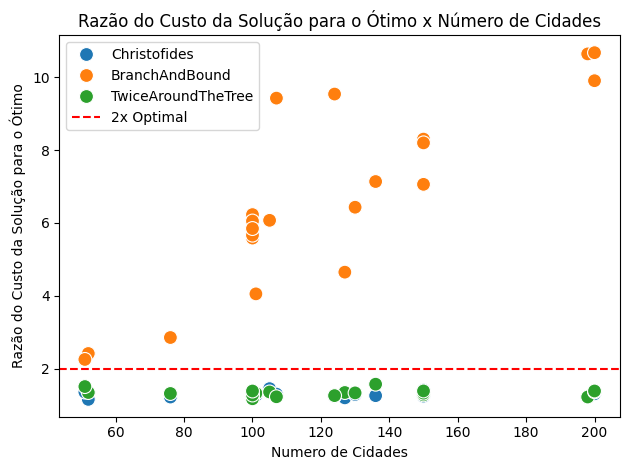

In [212]:
sns.scatterplot(data=df_exec, x='cities_number', y='solution_cost_rate', hue='heuristic', s=100)
plt.axhline(2,0, 210, linestyle='--', color='red', label='2x Optimal')
plt.legend(loc='upper left')
plt.ylabel('Razão do Custo da Solução para o Ótimo')
plt.xlabel('Numero de Cidades')
plt.title('Razão do Custo da Solução para o Ótimo x Número de Cidades')
plt.tight_layout()
plt.savefig('./src/figures/solution_cost_ratio_scatter.png', dpi=300);
plt.show()

Na tabela abaixo podemos consultar a lista de instâncias que foram utilizadas para a avaliação dos algoritmos, bem como o custo encontrado por cada algoritmo solução ótima e sua razão com o ótimo

In [213]:
df_exec['sol_detail'] = df_exec.apply(lambda x: f"{x['solution_cost']:,.2f} ({x['solution_cost_rate']:.2f}x)", axis=1)
df_exec.pivot_table(
    index='instance_name', columns='heuristic', values='sol_detail', aggfunc='first'
).reset_index(drop=False).rename_axis(None, axis=1)

,instance_name,BranchAndBound,Christofides,TwiceAroundTheTree
0,berlin52,"18,197.27 (2.41x)","8,690.54 (1.15x)","10,116.01 (1.34x)"
1,bier127,"549,685.23 (4.65x)","141,214.49 (1.19x)","158,637.61 (1.34x)"
2,ch130,"39,291.63 (6.43x)","7,858.86 (1.29x)","8,128.76 (1.33x)"
3,ch150,"46,084.20 (7.06x)","8,104.12 (1.24x)","8,333.47 (1.28x)"
4,d198,"167,937.11 (10.64x)","19,236.69 (1.22x)","19,218.43 (1.22x)"
5,eil101,"2,548.02 (4.05x)",794.25 (1.26x),830.54 (1.32x)
6,eil51,958.33 (2.25x),576.88 (1.35x),640.90 (1.50x)
7,eil76,"1,534.29 (2.85x)",654.66 (1.22x),707.15 (1.31x)
8,kroA100,"118,827.45 (5.58x)","28,765.25 (1.35x)","27,211.68 (1.28x)"
9,kroA150,"220,208.34 (8.30x)","34,930.53 (1.32x)","35,122.57 (1.32x)"


A menor razão encontrada por cada algoritmo é: 

In [214]:
df_exec.groupby('heuristic')['solution_cost_rate'].agg(['min','max'])

,min,max
heuristic,,
BranchAndBound,2.249608,10.676455
Christofides,1.152286,1.447353
TwiceAroundTheTree,1.168926,1.569811


Além disso podemos ver que a distribuição do ótimo encontrado pelo branch and bound é muito maior, e mais achatada que a dos outros algoritmos

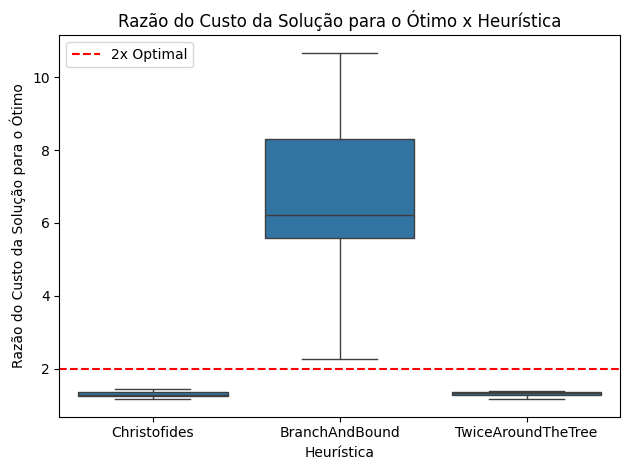

In [215]:
sns.boxplot(data=df_exec, y='solution_cost_rate', x='heuristic', showfliers=False)
plt.axhline(2,0, 210, linestyle='--', color='red', label='2x Optimal')
plt.legend(loc='upper left')
plt.ylabel('Razão do Custo da Solução para o Ótimo')
plt.xlabel('Heurística')
plt.title('Razão do Custo da Solução para o Ótimo x Heurística')
plt.tight_layout()
plt.savefig('./src/figures/solution_cost_ratio_boxplot.png', dpi=300);

In [216]:
df_exec.pivot_table(
    index='instance_name', columns='heuristic', values='solution_cost_rate', aggfunc='first'
).reset_index(drop=False).rename_axis(None, axis=1)

,instance_name,BranchAndBound,Christofides,TwiceAroundTheTree
0,berlin52,2.412791,1.152286,1.341291
1,bier127,4.647243,1.193880,1.341181
2,ch130,6.430708,1.286229,1.330402
3,ch150,7.059467,1.241439,1.276574
4,d198,10.642402,1.219055,1.217898
5,eil101,4.050902,1.262726,1.320417
6,eil51,2.249608,1.354174,1.504463
7,eil76,2.851849,1.216841,1.314411
8,kroA100,5.583472,1.351624,1.278624
9,kroA150,8.302230,1.316940,1.324181


Vamos agora comparar a diferença do Tempo e do Custo da Solução para as Heurísticas aproximativas.

/var/folders/33/gy7xm05x097chg59653_qr3m0000gn/T/ipykernel_59581/1024651827.py:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left')


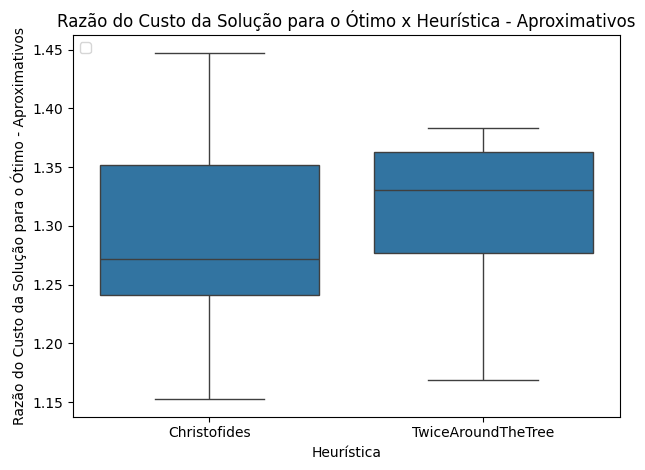

In [217]:
sns.boxplot(data=df_exec[df_exec.heuristic.isin(['Christofides', 'TwiceAroundTheTree'])], y='solution_cost_rate', x='heuristic', showfliers=False)
plt.legend(loc='upper left')
plt.ylabel('Razão do Custo da Solução para o Ótimo - Aproximativos')
plt.xlabel('Heurística')
plt.title('Razão do Custo da Solução para o Ótimo x Heurística - Aproximativos')
plt.tight_layout()
plt.savefig('./src/figures/solution_cost_ratio_boxplot_aproximativos.png', dpi=300);

Em geral parece que o Christofides tem uma performance melhor que o TwiceAroundTheTree, mas o TwiceAroundTheTree tem uma performance mais estável.

Vamos observar os dois algoritmos em relação ao tempo. Pelo visto apesar de ser em geral melhor, o CHristofides tem um tempo de execução muito maior do que o TwiceAroundTheTree

/var/folders/33/gy7xm05x097chg59653_qr3m0000gn/T/ipykernel_59581/4006915373.py:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left')


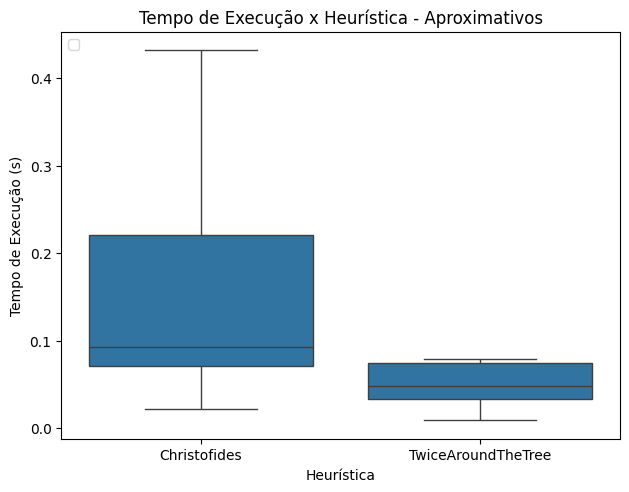

In [218]:
sns.boxplot(data=df_exec[df_exec.heuristic.isin(['Christofides', 'TwiceAroundTheTree'])], y='execution_time', x='heuristic', showfliers=False)
plt.legend(loc='upper left')
plt.tight_layout()
plt.ylabel('Tempo de Execução (s)')
plt.xlabel('Heurística')
plt.title('Tempo de Execução x Heurística - Aproximativos')
plt.savefig('./src/figures/execution_time_boxplot_aproximativos.png', dpi=300);


Aparentemente o tempo de execução do Christofides cresce muito mais rápido do que o TwiceAroundTheTree com o aumento da quantidade de cidades do problema do TSP.

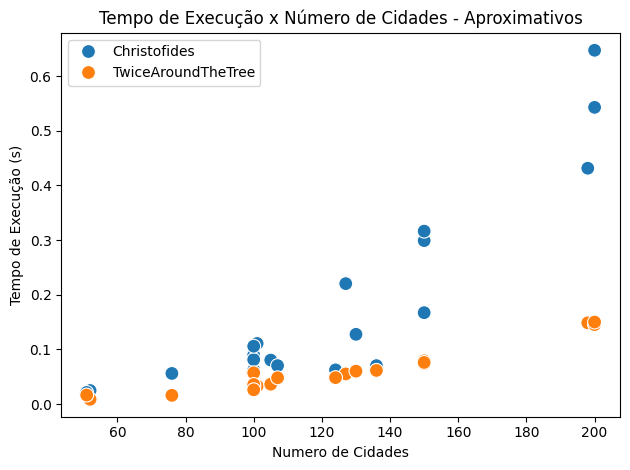

In [219]:
sns.scatterplot(data=df_exec[df_exec.heuristic.isin(['Christofides', 'TwiceAroundTheTree'])], x='cities_number', y='execution_time', hue='heuristic', s=100)

plt.legend(loc='upper left')
plt.ylabel('Tempo de Execução (s)')
plt.xlabel('Numero de Cidades')
plt.title('Tempo de Execução x Número de Cidades - Aproximativos')
plt.tight_layout()
plt.savefig('./src/figures/execution_time_scatter_aproximativos.png', dpi=300);
plt.show()

Porem aparentemente o Christofides é mais não parece mostrar tendencias de melhor performance em relação ao TwiceAroundTheTree quando o número de cidades aumenta.

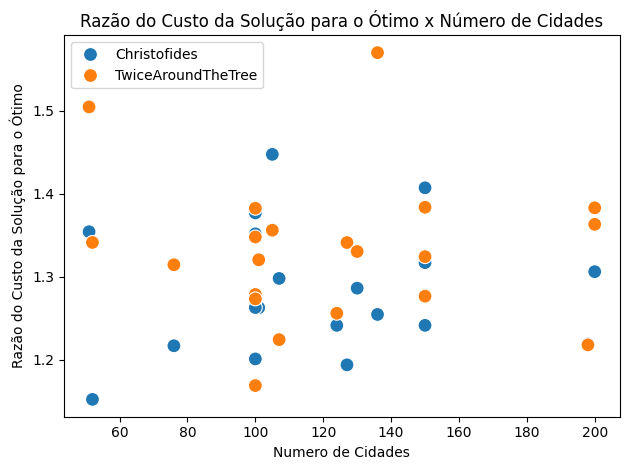

In [220]:
sns.scatterplot(data=df_exec[df_exec.heuristic.isin(['Christofides', 'TwiceAroundTheTree'])], x='cities_number', y='solution_cost_rate', hue='heuristic', s=100)
plt.legend(loc='upper left')
plt.ylabel('Razão do Custo da Solução para o Ótimo')
plt.xlabel('Numero de Cidades')
plt.title('Razão do Custo da Solução para o Ótimo x Número de Cidades')
plt.tight_layout()
plt.savefig('./src/figures/solution_cost_ratio_scatter_aproximativos.png', dpi=300);
plt.show()

Os algoritmos de Christofides e TwiceAroundTheTree são muito eficientes para os problemas observados 

/var/folders/33/gy7xm05x097chg59653_qr3m0000gn/T/ipykernel_59581/3793696877.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


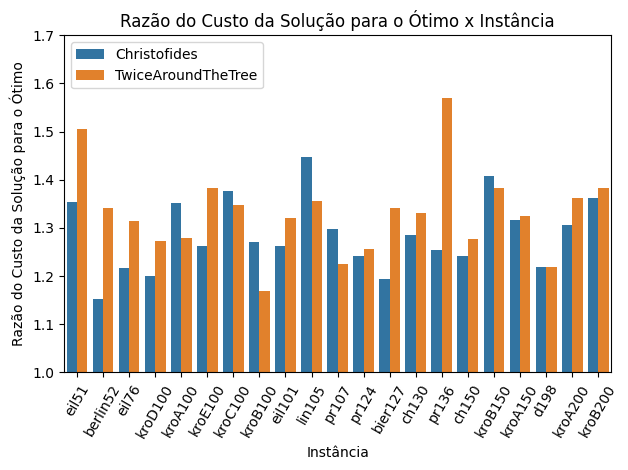

In [221]:
sns.barplot(
    data=df_exec[df_exec.heuristic.isin(['Christofides', 'TwiceAroundTheTree'])].sort_values(by='cities_number'), 
    y='solution_cost_rate',
    x='instance_name', 
    hue='heuristic',
    ci='sd'
)
plt.xticks(rotation=60)
plt.ylim(1, 1.7)
plt.legend(loc='upper left')
plt.ylabel('Razão do Custo da Solução para o Ótimo')
plt.xlabel('Instância');
plt.title('Razão do Custo da Solução para o Ótimo x Instância')
plt.tight_layout()
plt.savefig('./src/figures/solution_cost_ratio_barplot_aproximativos.png', dpi=300);

*** 

## Analisando o Branch and Bound

O BranchAndBound fica mais longe do ótimo conforme o número de cidades aumenta, enquanto os métodos aproximativos ficam mais próximos do ótimo conforme o número de cidades aumenta. O tempo de execução do BranchAndBound é muito maior que os métodos aproximativos, mas o tempo de execução dos métodos aproximativos aumenta mais rapidamente conforme o número de cidades aumenta.

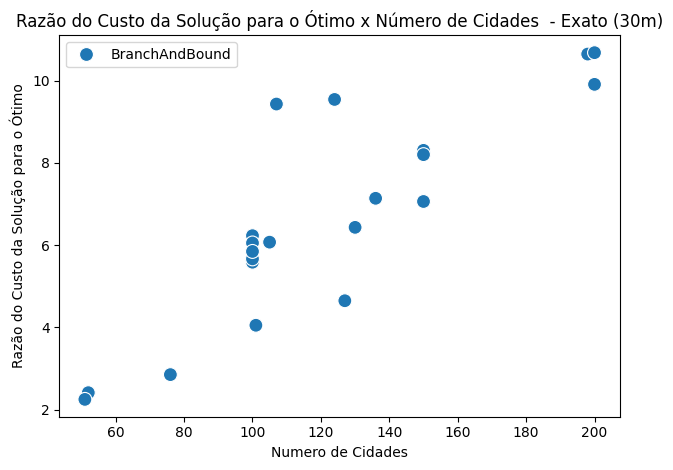

In [222]:
sns.scatterplot(data=df_exec[df_exec.heuristic.isin(['BranchAndBound'])], x='cities_number', y='solution_cost_rate', hue='heuristic', s=100)

plt.legend(loc='upper left')
plt.xlabel('Numero de Cidades')
plt.ylabel('Razão do Custo da Solução para o Ótimo')
plt.title('Razão do Custo da Solução para o Ótimo x Número de Cidades  - Exato (30m)')
plt.tight_layout()
plt.savefig('./src/figures/solution_result_scatter_exato.png', dpi=300);
plt.show()

Aparentemente um dos motivos disso acontecer é por que o número de soluções exploradas em 30 minutos decai com o aumento do número de cidades. Isso pode ser observado no gráfico abaixo.
O motivo, é que para cada subsolução ele tem que fazer cópias na memorio do caminho utilizado, isso aumenta proporcionalmente com o número de cidades.

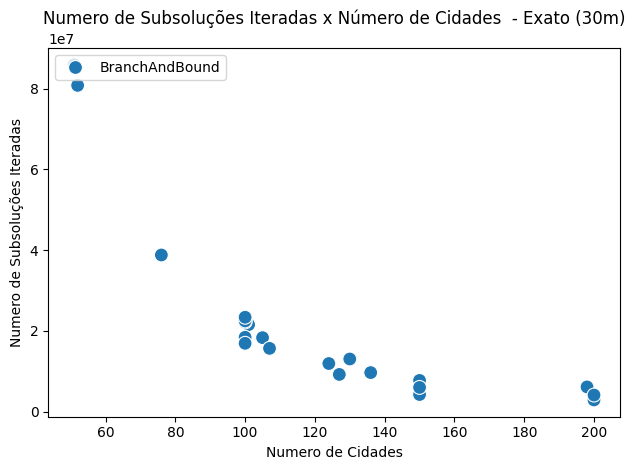

In [223]:
sns.scatterplot(data=df_exec[df_exec.heuristic.isin(['BranchAndBound'])], x='cities_number', y='iterations', hue='heuristic', s=100)
plt.legend(loc='upper left')
plt.xlabel('Numero de Cidades')
plt.ylabel('Numero de Subsoluções Iteradas')
plt.title('Numero de Subsoluções Iteradas x Número de Cidades  - Exato (30m)')
plt.tight_layout()
plt.savefig('./src/figures/iterations_result_scatter_exato.png', dpi=300);
plt.show()

Vamos observar como os problemas evoluem ao longo do tempo 

In [224]:
df_bnb_evolution

,instance_name,execution_time,iteration,solution_cost
0,berlin52,2025-01-15 12:59:02.305283,2751,27495.608338
1,berlin52,2025-01-15 12:59:02.318067,2752,27444.672769
2,berlin52,2025-01-15 12:59:02.330477,2867,27413.424593
3,berlin52,2025-01-15 12:59:02.340635,2892,27271.890094
4,berlin52,2025-01-15 12:59:02.351934,3099,27267.029176
...,...,...,...,...
3674,pr136,2025-01-15 14:30:59.254413,8029678,692309.261935
3675,pr136,2025-01-15 14:31:08.767949,8192915,692133.456135
3676,pr136,2025-01-15 14:31:15.765652,8192918,691502.716967
3677,pr136,2025-01-15 14:31:22.764413,8192942,691323.667019


In [225]:
df_bnb_base_detailed = df_bnb_base.drop(
    columns=['file', 'heuristic']
).rename(columns={'solution_cost': 'final_sol_cost', 'execution_time': 'total_executed_time'}).merge(
    df_tsp_euc.rename(columns={'Name': 'instance_name','CitiesNumber': 'cities_number', 'SolutionCost': 'optimal_cost'})
    ,on='instance_name', how='inner'
)
df_bnb_base_detailed

,instance_name,final_sol_cost,init_time,end_time,total_executed_time,iterations,memory_size,cities_number,optimal_cost
0,berlin52,18197.272873,2025-01-15 12:59:01.627210,2025-01-15 13:29:01.911601,30.004740,80800001,1097502,52,7542
1,bier127,549685.225554,2025-01-15 13:06:17.419252,2025-01-15 13:36:17.421932,30.000045,9214008,10557320,127,118282
2,ch130,39291.626748,2025-01-15 13:36:31.020180,2025-01-15 14:06:31.022127,30.000032,13037293,9809583,130,6110
3,ch150,46084.199917,2025-01-15 16:08:58.355430,2025-01-15 16:38:58.356947,30.000025,7732123,17558906,150,6528
4,d198,167937.107352,2025-01-15 18:10:33.033717,2025-01-15 18:41:20.040770,30.783451,6118468,17142203,198,15780
5,eil101,2548.017377,2025-01-15 03:11:22.669426,2025-01-15 03:41:22.670157,30.000012,21545069,5108301,101,629
6,eil51,958.333181,2025-01-15 12:29:00.861496,2025-01-15 12:59:00.861581,30.000001,85907915,892365,51,426
7,eil76,1534.294539,2025-01-15 13:59:04.711354,2025-01-15 14:29:04.711825,30.000008,38796184,2656224,76,538
8,kroA100,118827.447946,2025-01-15 02:41:16.092778,2025-01-15 03:11:16.093316,30.000009,18413284,5584105,100,21282
9,kroA150,220208.340324,2025-01-15 15:08:11.299350,2025-01-15 15:38:11.300743,30.000023,4239018,18319333,150,26524


In [226]:
df_bnb_f_ev = df_bnb_evolution.merge(
    df_bnb_base_detailed,
    on='instance_name',
    how='left'
)  
df_bnb_f_ev = pd.concat([
    df_bnb_f_ev,
    df_bnb_base_detailed[['instance_name', 'end_time','iterations','init_time','final_sol_cost', 'total_executed_time','optimal_cost']].rename(columns={
        'optimal_cost': 'optimal_cost', 'end_time': 'execution_time', 'final_sol_cost':'solution_cost', 'iterations': 'iteration'
    })
 ])
df_bnb_f_ev['moment'] = (df_bnb_f_ev['execution_time'].astype('datetime64[ns]') - df_bnb_f_ev['init_time'].astype('datetime64[ns]')).dt.total_seconds()/60
df_bnb_f_ev['it_rate'] = df_bnb_f_ev['iteration']/df_bnb_f_ev['iterations']
df_bnb_f_ev['log_it'] = np.log(df_bnb_f_ev['iteration'])
df_bnb_f_ev['solution_ratio'] = df_bnb_f_ev['solution_cost']/df_bnb_f_ev['optimal_cost']
df_bnb_f_ev

,instance_name,execution_time,iteration,solution_cost,final_sol_cost,init_time,end_time,total_executed_time,iterations,memory_size,cities_number,optimal_cost,moment,it_rate,log_it,solution_ratio
0,berlin52,2025-01-15 12:59:02.305283,2751,27495.608338,18197.272873,2025-01-15 12:59:01.627210,2025-01-15 13:29:01.911601,30.004740,80800001.0,1097502.0,52.0,7542,0.011301,0.000034,7.919720,3.645665
1,berlin52,2025-01-15 12:59:02.318067,2752,27444.672769,18197.272873,2025-01-15 12:59:01.627210,2025-01-15 13:29:01.911601,30.004740,80800001.0,1097502.0,52.0,7542,0.011514,0.000034,7.920083,3.638912
2,berlin52,2025-01-15 12:59:02.330477,2867,27413.424593,18197.272873,2025-01-15 12:59:01.627210,2025-01-15 13:29:01.911601,30.004740,80800001.0,1097502.0,52.0,7542,0.011721,0.000035,7.961021,3.634769
3,berlin52,2025-01-15 12:59:02.340635,2892,27271.890094,18197.272873,2025-01-15 12:59:01.627210,2025-01-15 13:29:01.911601,30.004740,80800001.0,1097502.0,52.0,7542,0.011890,0.000036,7.969704,3.616002
4,berlin52,2025-01-15 12:59:02.351934,3099,27267.029176,18197.272873,2025-01-15 12:59:01.627210,2025-01-15 13:29:01.911601,30.004740,80800001.0,1097502.0,52.0,7542,0.012079,0.000038,8.038835,3.615358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,kroE100,2025-01-15 16:29:23.787340,16920722,129000.701445,NaN,2025-01-15 15:59:23.787333,NaT,30.000000,NaN,NaN,NaN,22068,30.000000,NaN,16.644050,5.845600
17,lin105,2025-01-15 04:11:28.928751,18320675,87294.747700,NaN,2025-01-15 03:41:28.927529,NaT,30.000020,NaN,NaN,NaN,14379,30.000020,NaN,16.723541,6.070989
18,pr107,2025-01-15 04:41:35.391160,15669899,417684.753802,NaN,2025-01-15 04:11:35.390367,NaT,30.000013,NaN,NaN,NaN,44303,30.000013,NaN,16.567252,9.427911
19,pr124,2025-01-15 13:06:04.669220,11916538,563120.543559,NaN,2025-01-15 12:36:04.666950,NaT,30.000038,NaN,NaN,NaN,59030,30.000038,NaN,16.293438,9.539565


Aparentemnete no BranchAndBound ocorre pouca otimização ao longo do tempo, o algoritmo tem uma grande queda no início, mais vai ficando mais dificil de melhorar ao longo do tempo, se mantendo constante.

Cada linho no gráfico abaixo é uma instancia do TSP que o BranchAndBound tenta otimizar

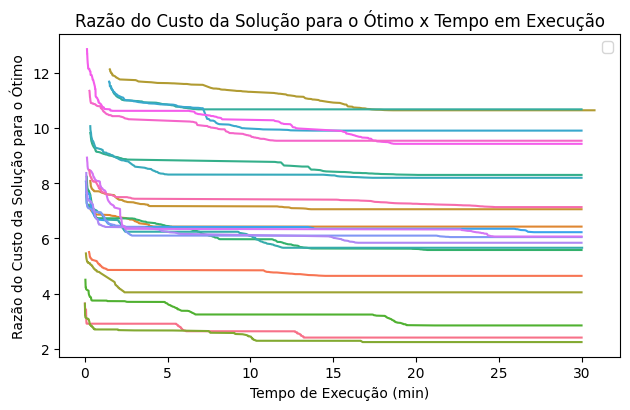

In [227]:
sns.lineplot(data=df_bnb_f_ev, x='moment', y='solution_ratio', hue='instance_name')
plt.ylabel('Razão do Custo da Solução para o Ótimo')
plt.xlabel('Tempo de Execução (min)')
plt.title('Razão do Custo da Solução para o Ótimo x Tempo em Execução')
plt.tight_layout()
plt.legend([])
plt.savefig('./src/figures/solution_ratio_evolution.png', dpi=300);

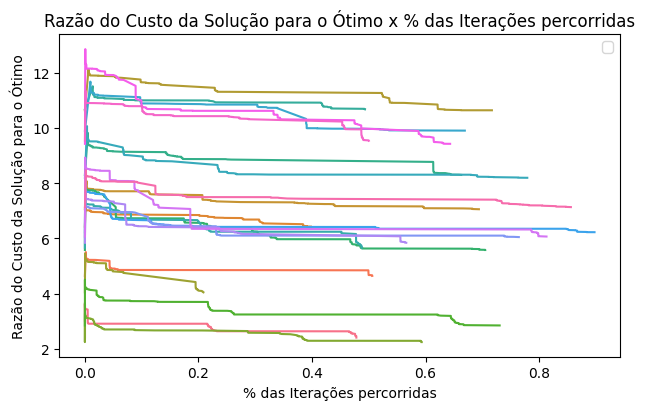

In [228]:
sns.lineplot(data=df_bnb_f_ev, x='it_rate', y='solution_ratio', hue='instance_name')
plt.ylabel('Razão do Custo da Solução para o Ótimo')
plt.xlabel('% das Iterações percorridas')
plt.title('Razão do Custo da Solução para o Ótimo x % das Iterações percorridas')
plt.tight_layout()
plt.legend([])
plt.savefig('./src/figures/solution_ratio_evolution_it.png', dpi=300);

O algoritmo continua tendo melhoras ao longo da quantidade de execuções e iterações, porém a melhora é mais significativa no início do processo. 


Vamos agora analisar o quanto que o algoritmo melhora desde a primeira solução até a solução final

In [229]:
df_bnb_first = df_bnb_f_ev.sort_values(by=['instance_name', 'execution_time'], ascending=[True, True]).drop_duplicates(subset=['instance_name'], keep='first')
df_bnb_first['start_rate'] = df_bnb_first['solution_cost']/df_bnb_first['optimal_cost']
df_bnb_first['end_rate'] = df_bnb_first['final_sol_cost']/df_bnb_first['optimal_cost']
df_bnb_first['improvement'] = df_bnb_first['start_rate'] - df_bnb_first['end_rate']   
df_bnb_first = df_bnb_first[[
    'instance_name', 'solution_cost', 'final_sol_cost', 'optimal_cost', 'start_rate', 'end_rate', 'improvement'
]].rename({
    'solution_cost': 'Custo Inicial', 'final_sol_cost': 'Custo Final', 'optimal_cost': 'Custo Ótimo',
    'start_rate': 'Razão Inicial', 'end_rate': 'Razão Final', 'improvement': 'Melhoria'
}, axis=1)

df_bnb_first

,instance_name,Custo Inicial,Custo Final,Custo Ótimo,Razão Inicial,Razão Final,Melhoria
0,berlin52,27495.608338,18197.272873,7542,3.645665,2.412791,1.232874
173,bier127,651607.682095,549685.225554,118282,5.508934,4.647243,0.861690
307,ch130,44084.002257,39291.626748,6110,7.215058,6.430708,0.784350
446,ch150,52772.689190,46084.199917,6528,8.084052,7.059467,1.024585
554,d198,191356.362951,167937.107352,15780,12.126512,10.642402,1.484110
747,eil101,3434.443892,2548.017377,629,5.460165,4.050902,1.409263
894,eil51,1551.328551,958.333181,426,3.641616,2.249608,1.392008
1085,eil76,2424.734394,1534.294539,538,4.506941,2.851849,1.655093
1285,kroA100,175255.376293,118827.447946,21282,8.234911,5.583472,2.651439
1528,kroA150,260510.312836,220208.340324,26524,9.821683,8.302230,1.519453


In [230]:
df_bnb_first['Melhoria'].mean()

np.float64(1.7078680027438824)

Em geral, podemos ver uma melhoria de 1.7 na razão entre o custo da solução inicial e o custo ótimo até o custo da solução final. Isso significa que, em média, o algoritmo de Branch and Bound conseguiu encontrar soluções 1.7 vezes melhores que a solução inicial.

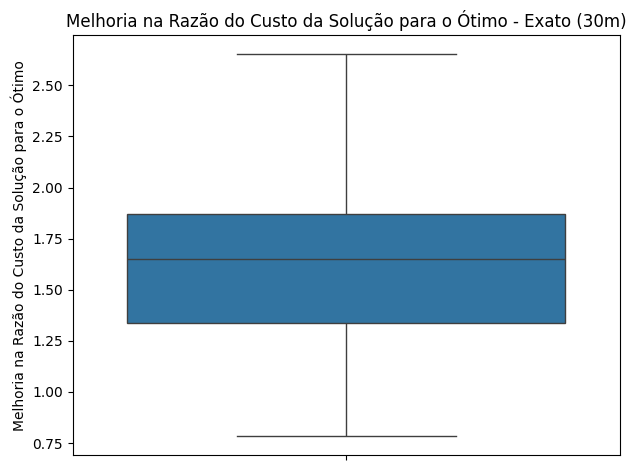

In [231]:
sns.boxplot(data=df_bnb_first, y='Melhoria', showfliers=False)
plt.ylabel('Melhoria na Razão do Custo da Solução para o Ótimo')
plt.title('Melhoria na Razão do Custo da Solução para o Ótimo - Exato (30m)')
plt.tight_layout()
plt.savefig('./src/figures/solution_improvement_boxplot.png', dpi=300);

O que acontece com o Branch and Bound em relação aos outros algoritmos, é que ele não tem um bom começo,  demora muito para estimar um bom upper bound, o que impede de podar soluções ruins. Porém, com o passar do tempo.

Talvez a solução seja combinar os dois algoritmos Exato e aproximativo, para em pouco tempo de execução atingirmos um resultado ótimo:

Executamos um algoritmo como o Christofides inicialmente e usamos seu custo como upper bound para o Branch and Bound, assim, o Branch and Bound terá um bom upper bound e poderá podar soluções ruins mais rapidamente.
